### Data Preparation

In [1]:
!curl -L -o lfwpeople.zip \
  https://www.kaggle.com/api/v1/datasets/download/atulanandjha/lfwpeople

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  232M  100  232M    0     0  18.2M      0  0:00:12  0:00:12 --:--:-- 22.8M


In [2]:
!unzip lfwpeople.zip && tar xvzf lfw-funneled.tgz

Streaming output truncated to the last 5000 lines.
lfw_funneled/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw_funneled/Delphine_Chuillot/
lfw_funneled/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw_funneled/Paul_LeClerc/
lfw_funneled/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw_funneled/Eddie_Jordan/
lfw_funneled/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw_funneled/Lionel_Richie/
lfw_funneled/Lionel_Richie/Lionel_Richie_0001.jpg
lfw_funneled/Lionel_Richie/Lionel_Richie_0002.jpg
lfw_funneled/Jose_Viegas_Filho/
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw_funneled/Roger_Mahony/
lfw_funneled/Roger_Mahony/Roger_Mahony_0001.jpg
lfw_funneled/Clay_Aiken/
lfw_funneled/Clay_Aiken/Clay_Aiken_0001.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0002.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0003.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0004.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0005.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0006.jpg
lfw_fun

#### Filtering identities with minimum 20 images

In [3]:
import os
from collections import defaultdict, Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, random_split, DataLoader

In [4]:
def get_identity_counts(root_dir):
    identity_counts = {}

    for identity in os.listdir(root_dir):
        identity_path = os.path.join(root_dir, identity)
        if not os.path.isdir(identity_path):
            continue

        num_images = len([
            f for f in os.listdir(identity_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

        identity_counts[identity] = num_images

    return identity_counts

def filter_identities(identity_counts, min_images=10):
    return {
        identity: count
        for identity, count in identity_counts.items()
        if count >= min_images
    }

root_dir = "lfw_funneled"
identity_counts = get_identity_counts(root_dir)

filtered_identities = filter_identities(identity_counts, min_images=20)

print(f"Total identities: {len(identity_counts)}")
print(f"Filtered identities: {len(filtered_identities)}")


Total identities: 5749
Filtered identities: 62


#### Dataset creation from ImageFolder

In [5]:
class FilteredImageFolder(Dataset):
    def __init__(self, root, allowed_identities, transform=None):
        self.root = root
        self.transform = transform
        self.allowed_identities = sorted(allowed_identities)

        self.class_to_idx = {
            cls_name: idx for idx, cls_name in enumerate(self.allowed_identities)
        }

        self.samples = []

        for cls_name in self.allowed_identities:
            cls_dir = os.path.join(root, cls_name)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    path = os.path.join(cls_dir, fname)
                    label = self.class_to_idx[cls_name]
                    self.samples.append((path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
dataset = FilteredImageFolder(
    root="lfw_funneled",
    allowed_identities=filtered_identities
)

#### EDA

##### Total classes & images

In [7]:
num_classes = len(dataset.class_to_idx)
num_images = len(dataset)

print(f"total classes: {num_classes} | total_images: {num_images}")

total classes: 62 | total_images: 3023


##### Distribution of image count per class

Text(0.5, 1.0, 'distribution of image counts per class')

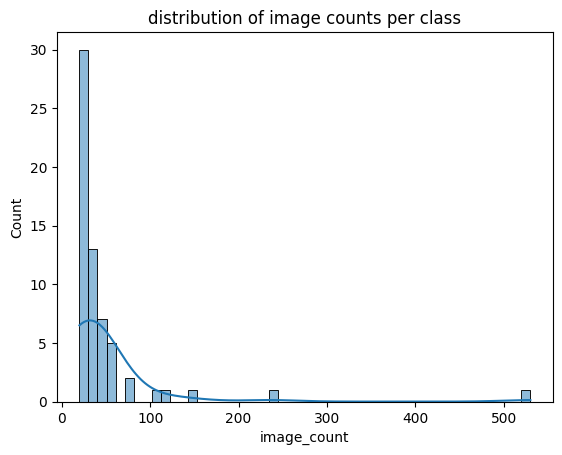

In [8]:
labels = [label for _, label in dataset.samples]
class_counts = Counter(labels)
class_counts_named = dict(zip(dataset.class_to_idx.keys(),
                              class_counts.values()))

df_class_counts = pd.DataFrame(list(class_counts_named.items()),
                               columns=["class", "image_count"])

sns.histplot(df_class_counts.image_count, kde=True, bins=50)
plt.title("distribution of image counts per class")

##### Sample images

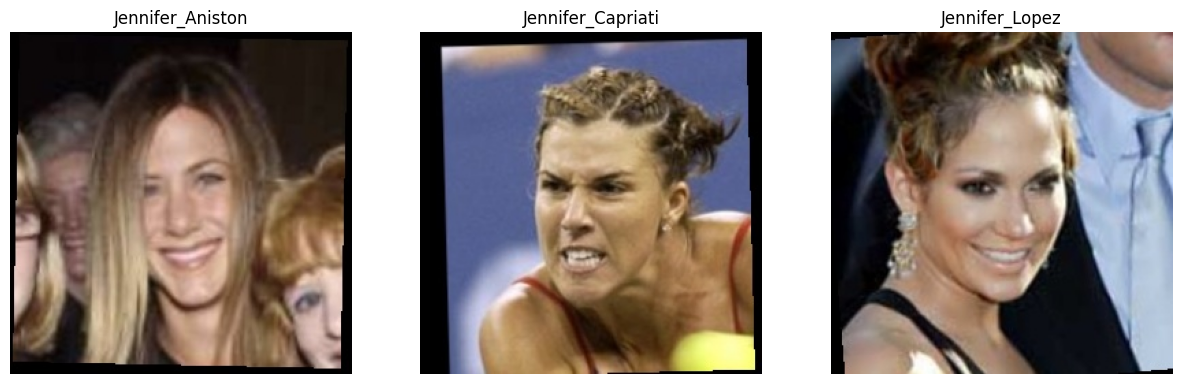

In [9]:
idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

samples = [1796, 1839, 1855]

for i in range(len(samples)):
  img, label = dataset[samples[i]]
  tensor_img = transforms.ToTensor()(img)

  axes[i].imshow(tensor_img.permute(1, 2, 0))
  axes[i].set_title(idx_to_class[label])
  axes[i].axis("off")

plt.show()

##### Image sizes & channels

In [10]:
sizes = [img.size for img, _ in dataset]
channels = [len(img.getbands()) for img, _ in dataset]

df_summary = pd.DataFrame({
    "image_sizes": sizes[:3],
    "channels": channels[:3]
})

df_summary

,image_sizes,channels
0,"(250, 250)",3
1,"(250, 250)",3
2,"(250, 250)",3


In [11]:
all_imgs = torch.stack([transforms.ToTensor()(img) for img, _ in dataset])
mean = all_imgs.mean(dim=[0,2,3])
std = all_imgs.std(dim=[0,2,3])

print(f"mean: {mean} | std: {std}")

mean: tensor([0.4304, 0.3777, 0.3368]) | std: tensor([0.3000, 0.2728, 0.2655])


#### Spliting dataset into train, val, test

In [12]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.02
    ),
    transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=3)],
        p=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform

train_dl = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True
)

val_dl = DataLoader(
    dataset=val_ds,
    batch_size=32,
    shuffle=False
)

print(f"Training batches: {len(train_dl)}\nValidation batches: {len(val_dl)}")

Training batches: 67
Validation batches: 15


In [13]:
train_labels = set(
    dataset.samples[i][1] for i in train_ds.indices
)

val_labels = set(
    dataset.samples[i][1] for i in val_ds.indices
)

len(train_labels), len(val_labels)

(62, 62)

### Model Training

#### Defining the model

In [22]:
class FaceRecognition(nn.Module):
  def __init__(self, embedding_dim=512, droprate=0.2, num_classes=10):
    super().__init__()

    self.backbone = models.mobilenet_v3_large(
        weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

    in_features = self.backbone.classifier[0].in_features
    self.backbone.classifier = nn.Identity()

    self.embedding = nn.Sequential(
        nn.Linear(in_features, embedding_dim),
        nn.BatchNorm1d(embedding_dims)
    )

    self.classifier = nn.Sequential(
        nn.Dropout(droprate),
        nn.Linear(embedding_dim, num_classes)
    )

  def forward(self, x):
    features = self.backbone(x)
    embeddings = self.embedding(features)
    logits = self.classifier(embeddings)

    return logits, embeddings

#### Preparing the model

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(embedding_dim=512, droprate=0.2):
  model = FaceRecognition(embedding_dim,
                          droprate,
                          num_classes=len(train_labels))
  model.to(device)
  print(f"model is on {device}")

  return model

def configure_backbone(model, unfreeze_blocks=0):
  if unfreeze_blocks > 0:
    for p in model.backbone.features[-unfreeze_blocks:].parameters():
      p.requires_grad = True
  else:
    for p in model.backbone.parameters():
      p.requires_grad = False

#### Training & validation setup

In [16]:
def train_one_epoch(train_dl, model, optimizer, loss_fn):
  model.train()
  running_loss, total_preds, correct_preds = 0., 0, 0

  for i, (inputs, labels) in tqdm(enumerate(train_dl), desc="Training"):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs, embeddings = model(inputs)

    loss = loss_fn(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    total_preds += labels.size(0)
    correct_preds += outputs.argmax(1).eq(labels).sum().item()

  epoch_loss = running_loss / len(train_dl)
  epoch_accuracy = correct_preds / total_preds

  return epoch_loss, epoch_accuracy


def validate(val_dl, model, loss_fn):
  model.eval()
  running_loss, total_preds, correct_preds = 0., 0, 0

  with torch.no_grad():
    for i, (inputs, labels) in tqdm(enumerate(val_dl), desc="Validating"):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs, embeddings = model(inputs)
      loss = loss_fn(outputs, labels)

      running_loss += loss.item()
      total_preds += labels.size(0)
      correct_preds += outputs.argmax(1).eq(labels).sum().item()

  epoch_loss = running_loss / len(train_dl)
  epoch_accuracy = correct_preds / total_preds

  return epoch_loss, epoch_accuracy


#### Tuning hyperparameters: learning_rate, embedding_dim, and unfreezed backbone blocks

In [17]:
learning_rates = [0.0001, 0.003, 0.001]
embeddings = [128, 256, 512]
unfreeze_blocks = [0, 3]

result = []

for emb in embeddings:
  print(f"embedding dim: {emb}")

  for unfreeze_n in unfreeze_blocks:
    print(f"unfreeze_block: {unfreeze_n}")

    for lr in learning_rates:
      print(f"learning rate: {lr}")

      model = build_model(embedding_dim=emb)

      configure_backbone(model, unfreeze_blocks=unfreeze_n)

      optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                                    model.parameters()),
                            lr=lr)
      loss_fn = nn.CrossEntropyLoss()

      loss, accuracy = train_one_epoch(train_dl, model, optimizer, loss_fn)
      vloss, vaccuracy = validate(val_dl, model, loss_fn)

      print(emb, unfreeze_n, lr, loss, accuracy, vloss, vaccuracy, end="\n\n")
      result.append((emb, unfreeze_n, lr, loss, accuracy, vloss, vaccuracy))


embedding dim: 128
unfreeze_block: 0
learning rate: 0.0001
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 128MB/s]


model is on cuda


Training: 67it [00:09,  7.26it/s]
Validating: 15it [00:01,  9.28it/s]


128 0 0.0001 3.8846284595888054 0.10207939508506617 0.8156861333704707 0.1986754966887417

learning rate: 0.003
model is on cuda


Training: 67it [00:07,  8.52it/s]
Validating: 15it [00:01,  9.79it/s]


128 0 0.003 2.2971002290497964 0.46975425330812853 0.5500255520664045 0.3465783664459161

learning rate: 0.001
model is on cuda


Training: 67it [00:07,  8.50it/s]
Validating: 15it [00:01,  9.84it/s]


128 0 0.001 2.658899625735496 0.43005671077504726 0.5739641758932996 0.33995584988962474

unfreeze_block: 3
learning rate: 0.0001
model is on cuda


Training: 67it [00:12,  5.53it/s]
Validating: 15it [00:01,  9.17it/s]


128 3 0.0001 3.3357083975379145 0.2660680529300567 0.5891635204429058 0.37748344370860926

learning rate: 0.003
model is on cuda


Training: 67it [00:10,  6.14it/s]
Validating: 15it [00:01, 10.76it/s]


128 3 0.003 2.148628269558522 0.4862948960302457 5.080324599991983 0.10596026490066225

learning rate: 0.001
model is on cuda


Training: 67it [00:10,  6.11it/s]
Validating: 15it [00:01, 10.46it/s]


128 3 0.001 1.9613146781921387 0.5784499054820416 0.3500802979540469 0.6710816777041942

embedding dim: 256
unfreeze_block: 0
learning rate: 0.0001
model is on cuda


Training: 67it [00:07,  8.58it/s]
Validating: 15it [00:01,  9.72it/s]


256 0 0.0001 3.745856779724804 0.16540642722117202 0.7567844426454003 0.2119205298013245

learning rate: 0.003
model is on cuda


Training: 67it [00:07,  8.47it/s]
Validating: 15it [00:01,  9.73it/s]


256 0 0.003 2.0319407128576024 0.5085066162570888 0.5274467450469288 0.37527593818984545

learning rate: 0.001
model is on cuda


Training: 67it [00:07,  8.98it/s]
Validating: 15it [00:01,  7.71it/s]


256 0 0.001 2.2960444955683466 0.4621928166351607 0.6150046106594712 0.293598233995585

unfreeze_block: 3
learning rate: 0.0001
model is on cuda


Training: 67it [00:11,  5.69it/s]
Validating: 15it [00:01,  8.38it/s]


256 3 0.0001 3.1623725286170616 0.2939508506616257 0.5371047863319739 0.4304635761589404

learning rate: 0.003
model is on cuda


Training: 67it [00:12,  5.44it/s]
Validating: 15it [00:01, 10.91it/s]


256 3 0.003 1.9682018347640535 0.5283553875236295 1.6901430870170024 0.0772626931567329

learning rate: 0.001
model is on cuda


Training: 67it [00:11,  6.06it/s]
Validating: 15it [00:01, 10.63it/s]


256 3 0.001 1.7107972324784122 0.6143667296786389 0.4934467913499519 0.4260485651214128

embedding dim: 512
unfreeze_block: 0
learning rate: 0.0001
model is on cuda


Training: 67it [00:07,  9.48it/s]
Validating: 15it [00:01,  7.54it/s]


512 0 0.0001 3.4912752037617696 0.23534971644612476 0.6983641902012612 0.23399558498896247

learning rate: 0.003
model is on cuda


Training: 67it [00:07,  9.14it/s]
Validating: 15it [00:01,  9.71it/s]


512 0 0.003 1.9674370395603464 0.526937618147448 0.5456434861937566 0.36644591611479027

learning rate: 0.001
model is on cuda


Training: 67it [00:07,  8.42it/s]
Validating: 15it [00:01,  9.76it/s]


512 0 0.001 2.0495240545984523 0.5113421550094518 0.6085203370051597 0.3333333333333333

unfreeze_block: 3
learning rate: 0.0001
model is on cuda


Training: 67it [00:11,  6.03it/s]
Validating: 15it [00:01, 10.84it/s]


512 3 0.0001 2.9403446948350367 0.35302457466918713 0.5357821806153255 0.41721854304635764

learning rate: 0.003
model is on cuda


Training: 67it [00:11,  6.05it/s]
Validating: 15it [00:01, 10.74it/s]


512 3 0.003 1.8644657748848645 0.5463137996219282 6.085100202418086 0.09492273730684327

learning rate: 0.001
model is on cuda


Training: 67it [00:11,  6.05it/s]
Validating: 15it [00:01, 10.87it/s]

512 3 0.001 1.4810889954887219 0.6587901701323251 0.423255331480681 0.5231788079470199



In [18]:
columns = ["embedding_dims", "unfreeze_blocks", "lr",
           "loss", "acc", "vloss", "vacc"]
df_result = pd.DataFrame(result, columns=columns)

df_result

,embedding_dims,unfreeze_blocks,lr,loss,acc,vloss,vacc
0,128,0,0.0001,3.884628,0.102079,0.815686,0.198675
1,128,0,0.0030,2.297100,0.469754,0.550026,0.346578
2,128,0,0.0010,2.658900,0.430057,0.573964,0.339956
3,128,3,0.0001,3.335708,0.266068,0.589164,0.377483
4,128,3,0.0030,2.148628,0.486295,5.080325,0.105960
5,128,3,0.0010,1.961315,0.578450,0.350080,0.671082
6,256,0,0.0001,3.745857,0.165406,0.756784,0.211921
7,256,0,0.0030,2.031941,0.508507,0.527447,0.375276
8,256,0,0.0010,2.296044,0.462193,0.615005,0.293598
9,256,3,0.0001,3.162373,0.293951,0.537105,0.430464


#### Training the model

In [24]:
epochs = 10
best_val_accuracy = 0.
checkpoint_path = "mobilenetv3_face_recog_v1_{epoch:02d}_{val_accuracy:.3f}.pth"

embedding_dim = 128
unfreeze_blocks = 3
learning_rate = 0.001

model = build_model(embedding_dim=embedding_dim)

configure_backbone(model, unfreeze_blocks=unfreeze_blocks)

optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                              model.parameters()),
                      lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
  print(f"\nEpoch: {epoch + 1}")

  train_result = train_one_epoch(train_dl, model, optimizer, loss_fn)
  print(f"Train | Loss: {train_result[0]} | Accuracy: {train_result[1]}")

  val_result = validate(val_dl, model, loss_fn)
  print(f"Val | Loss: {val_result[0]} | Accuracy: {val_result[1]}")

  if val_result[1] > best_val_accuracy:
    best_val_accuracy = val_result[1]
    checkpoint = checkpoint_path.format(epoch=epoch + 1,
                                        val_accuracy=val_result[1])
    torch.save(model.state_dict(), checkpoint)
    print(f"Saved best model with val_accuracy: {val_result[1]}")

model is on cuda

Epoch: 1


Training: 67it [00:11,  6.01it/s]


Train | Loss: 2.0047180083260607 | Accuracy: 0.5652173913043478


Validating: 15it [00:02,  6.68it/s]


Val | Loss: 0.3610799152459671 | Accuracy: 0.6269315673289183
Saved best model with val_accuracy: 0.6269315673289183

Epoch: 2


Training: 67it [00:12,  5.38it/s]


Train | Loss: 0.5696551085852865 | Accuracy: 0.9120982986767486


Validating: 15it [00:01, 10.55it/s]


Val | Loss: 0.18834940888988438 | Accuracy: 0.8388520971302428
Saved best model with val_accuracy: 0.8388520971302428

Epoch: 3


Training: 67it [00:11,  5.84it/s]


Train | Loss: 0.16841857563426246 | Accuracy: 0.9914933837429112


Validating: 15it [00:01, 10.63it/s]


Val | Loss: 0.10589873523854498 | Accuracy: 0.9072847682119205
Saved best model with val_accuracy: 0.9072847682119205

Epoch: 4


Training: 67it [00:11,  5.98it/s]


Train | Loss: 0.07400309578029078 | Accuracy: 0.9976370510396976


Validating: 15it [00:01, 10.47it/s]


Val | Loss: 0.08774183090053388 | Accuracy: 0.9094922737306843
Saved best model with val_accuracy: 0.9094922737306843

Epoch: 5


Training: 67it [00:11,  6.04it/s]


Train | Loss: 0.03655209456250739 | Accuracy: 0.9995274102079396


Validating: 15it [00:01, 10.68it/s]


Val | Loss: 0.07433084876679663 | Accuracy: 0.9293598233995585
Saved best model with val_accuracy: 0.9293598233995585

Epoch: 6


Training: 67it [00:11,  6.00it/s]


Train | Loss: 0.04136428072937389 | Accuracy: 0.9985822306238186


Validating: 15it [00:01, 10.81it/s]


Val | Loss: 0.0776112824678421 | Accuracy: 0.9139072847682119

Epoch: 7


Training: 67it [00:11,  6.03it/s]


Train | Loss: 0.1466064960487298 | Accuracy: 0.9839319470699432


Validating: 15it [00:01, 10.81it/s]


Val | Loss: 0.18097521765018576 | Accuracy: 0.7704194260485652

Epoch: 8


Training: 67it [00:11,  6.03it/s]


Train | Loss: 0.05644455727245381 | Accuracy: 0.9976370510396976


Validating: 15it [00:01, 10.87it/s]


Val | Loss: 0.07015767952065859 | Accuracy: 0.9072847682119205

Epoch: 9


Training: 67it [00:11,  6.00it/s]


Train | Loss: 0.11437279811657186 | Accuracy: 0.9810964083175804


Validating: 15it [00:01, 10.60it/s]


Val | Loss: 0.11886525665646169 | Accuracy: 0.8520971302428256

Epoch: 10


Training: 67it [00:11,  5.78it/s]


Train | Loss: 0.07297063424293675 | Accuracy: 0.9858223062381852


Validating: 15it [00:01, 10.95it/s]

Val | Loss: 0.10039862890296908 | Accuracy: 0.8741721854304636


### Using the Model

#### Testing the trained model with test dataset

In [26]:
weights_file = "mobilenetv3_face_recog_v1_05_0.929.pth"

test_ds.dataset.transform = val_transform

test_dl = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=True
)

model = build_model(embedding_dim=embedding_dim)
model.load_state_dict(torch.load(weights_file))
model.to(device)
model.eval()

for inputs, labels in test_dl:
  inputs, labels = inputs.to(device), labels.to(device)
  break

outputs, embeddings = model(inputs)
total_preds = labels.size(0)
correct_preds = outputs.argmax(1).eq(labels).sum().item()
correct_preds / total_preds

model is on cuda


0.9375

#### Inferencing

In [27]:
import numpy as np
from io import BytesIO
from urllib import request
from PIL import Image


def pytorch_preprocessing(X):
  X = X / 255.

  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

  # batch, height, width, channels => batch, channels, height, width
  X = X.transpose(0, 3, 1, 2)
  X = (X - mean) / std

  return X.astype(np.float32)


def download_image(url):
    req = request.Request(
        url,
        headers={
            "User-Agent": "Mozilla/5.0"
        }
    )
    with request.urlopen(req) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def preprocess(img):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    small = img.resize((224, 224), Image.NEAREST) # type: ignore
    x = np.array(small, dtype='float32')
    batch = np.expand_dims(x, axis=0)
    return pytorch_preprocessing(batch)

url = "http://bit.ly/4j4Y0Uo"
img = download_image(url)
X = preprocess(img)
X = torch.Tensor(X).to(device)

classes = dataset.class_to_idx.keys()
pred = np.array(model(X)[0].data[0].cpu())

dict(zip(classes, pred.tolist()))

{'Alejandro_Toledo': -0.10065241158008575,
 'Alvaro_Uribe': -1.710341453552246,
 'Amelie_Mauresmo': 0.9172394275665283,
 'Andre_Agassi': 0.3259609043598175,
 'Angelina_Jolie': 2.8430893421173096,
 'Ariel_Sharon': 0.6851033568382263,
 'Arnold_Schwarzenegger': -2.0387139320373535,
 'Atal_Bihari_Vajpayee': -1.0158271789550781,
 'Bill_Clinton': -0.16287273168563843,
 'Carlos_Menem': -0.7326678037643433,
 'Colin_Powell': -0.8971025943756104,
 'David_Beckham': 1.2848494052886963,
 'Donald_Rumsfeld': -0.20128154754638672,
 'George_Robertson': -1.0274027585983276,
 'George_W_Bush': -1.7318456172943115,
 'Gerhard_Schroeder': -0.2321716994047165,
 'Gloria_Macapagal_Arroyo': -1.9624887704849243,
 'Gray_Davis': -1.674349308013916,
 'Guillermo_Coria': 0.2687700092792511,
 'Hamid_Karzai': 1.7661107778549194,
 'Hans_Blix': 2.4598686695098877,
 'Hugo_Chavez': -1.1070106029510498,
 'Igor_Ivanov': -1.759613275527954,
 'Jack_Straw': -0.6563314199447632,
 'Jacques_Chirac': -0.5741315484046936,
 'Jean_Chre

#### Saving the model

In [29]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 16.3 MB/s eta 0:00:00


In [31]:
dummy_input = torch.randn(1, 3, input_size, input_size).to(device)
onnx_path = "face_recognition_v202510191408.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    external_data=False,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    },
)

print(f"Model saved to {onnx_path}")

/tmp/ipython-input-3875817833.py:4: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `FaceRecognition([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `FaceRecognition([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 93 of general pattern rewrite rules.
Model saved to face_recognition_v202510191408.onnx
